In [7]:
# v1 was just vanila.

# v2: 24.09.01. 
#   1. Doing the CV (10 folds)
#   2. Early stopping with patience parameter.
#   3. Takings n steps into account. 

# v3: 24.10.15 - 29
#   1. No CV. No Early Stopping as well. 
#       Adding early stopping may be an option, but it it not super necessary.
#   2. Adding tau param. h(t) = f((1-tau) * h(t-1) + tau * x(t)) => This is what basically CT-RNN is about.

# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt

# seed random number generator for reproducibility
torch.manual_seed(0)
np.random.seed(0)

## ---------------------------------- ##
## ------------ FIX down ------------ ##
## ---------------------------------- ##

# input
input_size  = 1   # Input feature size
hidden_size = 128  # Number of features in the hidden state
output_size = 2   # Output feature size (stim rating / click profiles)
output_name = ['stim_rating', 'clicks'] # 'stim_rating' 'clicks'
taus        = np.linspace(0, 1, 10)
noise_sig   = 0.01

# params
learning_rate = 1e-3 # 
n_epochs      = 1000
batch_size    = 32   # or 9 for condition. so far at the trial-level
device        = 'cpu' # mps
targfolder    = 'label-RatingClicks_loss-MSECE'
if not (os.path.isdir(targfolder)):
    os.mkdir(targfolder)

## ---------------------------------- ##
## ------------- FIX up ------------- ##
## ---------------------------------- ##

# Q. why no Cross-Validation?
# A. no differences across inputs.

# Input: n_batch, n_seqlen, n_dim
class PainRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, tau):
        super().__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alpha       = tau # [0, 1] balances the effect of the input and hidden.
                               # having it as one is just same with vanila RNN
        self.i2h         = nn.Linear(input_size, hidden_size)
        self.h2h         = nn.Linear(hidden_size, hidden_size)
        self.h2o         = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, init_hidden=None):
        hidden_units  = []
        output_units  = []
        seq_len       = input.size(1) # sequence length
        
        for i in range(seq_len):
             if (i == 0) and (init_hidden is None):
                 h_t = torch.zeros(input.size(0), self.hidden_size)
             elif (i == 0) and (init_hidden is not None):
                 h_t = init_hidden
             else:
                 h_t = hidden_unit
                 
             h_t           = h_t.to(device)    
             x_t           = input[:, i, :]
             hidden_unit   = torch.relu(self.i2h(x_t) + self.h2h(h_t))
             hidden_unit   = h_t * (1 - self.alpha) + hidden_unit * self.alpha
             output_unit   = self.h2o(hidden_unit)
            
             hidden_units.append(hidden_unit)
             output_units.append(output_unit)
        
        hidden_units = torch.stack(hidden_units, dim = 1)
        output_units = torch.stack(output_units, dim = 1)
        return output_units, hidden_units
    
# Load input and output data
inputoutputs = sio.loadmat('InOutputs')
Inputs       = inputoutputs['Inputs']
Outputs      = inputoutputs['Outputs']

Xnp = []
ynp = []
for cond_i in range(len(Outputs)):
    Xnp.append(np.tile(Inputs[cond_i, :], (Outputs[cond_i][0].shape[0], 1)))
    ynp.append(Outputs[cond_i][0])
Xnp = np.expand_dims(np.vstack(Xnp), axis=2)
ynp = np.vstack(ynp)
if len(output_name) == 1 and output_name[0] == 'stim_rating': 
    ynp = np.expand_dims(ynp[:, :, 0], axis = 2)
elif len(output_name) == 1 and output_name[0] == 'clicks':
    ynp = np.expand_dims(ynp[:, :, 1], axis = 2)

X = torch.from_numpy(Xnp).to(torch.float32)
y = torch.from_numpy(ynp).to(torch.float32)

torch.Size([1538, 44, 1])

In [ ]:

# Combine inputs and outputs into a dataset
dataset    = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model instantiation
for i, tau in enumerate(taus):
    addstr      = 'tau_%.2f' % tau
    pain_rnn    = PainRNN(input_size, hidden_size, output_size, tau).to(device)
    optimizer   = optim.Adam(pain_rnn.parameters(), lr=learning_rate)
    criterion1  = nn.MSELoss()              # For intensity.
    criterion2  = nn.CrossEntropyLoss()     # For clicks.
    loss_epochs = []
    for epoch in range(n_epochs):
        for inputs, targets in dataloader:
            add_noise = np.random.normal(0, noise_sig, inputs.shape)
            inputs += torch.from_numpy(add_noise).to(torch.float32)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs, _ = pain_rnn(inputs)  # Capture both outputs and hidden states
            loss1 = criterion1(outputs[:, :, 0], targets[:, :, 0])
            loss2 = criterion2(outputs[:, :, 1], targets[:, :, 1])
            loss  = loss1 + loss2
            # loss = criterion1(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epochs.append(loss.item())
        
        if ((epoch+1) % 10) == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f} in {i+1} of {len(taus)}')
            
    out_t, h_t = pain_rnn(torch.from_numpy(np.expand_dims(Inputs, axis = 2)).to(torch.float32))
    out_t      = out_t.detach().numpy()
    h_t        = h_t.detach().numpy()

    fig, axes = plt.subplots(3, 3, figsize = (9, 9))
    axes[0, 0].plot(loss_epochs)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')

    axes[0, 1].plot(np.mean(h_t, 0))
    axes[0, 1].set_xlabel('time')
    axes[0, 1].set_ylabel('Hidden Unit activations')
    
    axes[2, 0].plot(Inputs.T)
    axes[2, 0].set_xlabel('time')
    axes[2, 0].set_ylabel('Training Input')
    
    for i in range(output_size):
        axes[1, i].plot(out_t[:, :, i].T)
        axes[1, i].set_xlabel('time')
        axes[1, i].set_ylabel(f'Outputs {output_name[i]}')
        
        axes[2, i+1].imshow(y[:, :, i], aspect='auto')
        axes[2, i+1].set_xlabel('time')
        axes[2, i+1].set_ylabel(f'Training {output_name[i]}')
    
    
    sio.savemat(os.path.join(targfolder, ('HiddenLayers_' + addstr + '.mat')), 
                {'out_t': out_t, 'h_t': h_t, 'loss_epochs': loss_epochs, 
                 'i2h':pain_rnn.i2h.weight.detach().numpy(), 
                 'h2h':pain_rnn.h2h.weight.detach().numpy(), 
                 'h2o':pain_rnn.h2o.weight.detach().numpy()})

    plt.savefig(os.path.join(targfolder, ('HiddenLayers_' + addstr + '.png')))
    plt.close()
    

In [71]:
targets.type

<function Tensor.type>

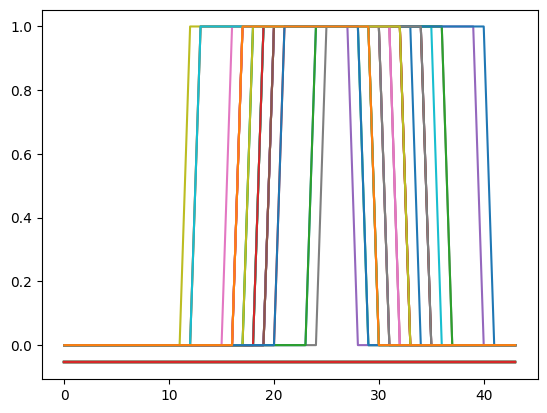

In [8]:
plt.plot(torch.squeeze(targets[:, :, 1]).detach().T)
plt.plot(torch.squeeze(outputs[:, :, 1]).detach().T)

In [ ]:
# # Load input and output data
# inputoutputs = sio.loadmat('InOutputs')
# Inputs = inputoutputs['Inputs']
# Outputs = inputoutputs['Outputs']

# Xnp = []
# ynp = []
# for cond_i in range(len(Outputs)):
#     Xnp.append(np.tile(Inputs[cond_i, :], (Outputs[cond_i][0].shape[0], 1)))
#     ynp.append(Outputs[cond_i][0])
# Xnp = np.expand_dims(np.vstack(Xnp), axis=2)
# ynp = np.vstack(ynp)
# X = torch.from_numpy(Xnp).to(torch.float32)
# y = torch.from_numpy(ynp).to(torch.float32)

# # Combine inputs and outputs into a dataset
# dataset = TensorDataset(X, y)

# # Initialize k-fold cross-validation
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

# # Lists to store training losses, validation losses, hidden states, and outputs
# train_losses_all_epochs = []
# val_losses_all_epochs = []
# fold_hidden_states = []  # Store hidden states for each fold
# fold_outputs = []  # Store outputs for each fold

# # Model instantiation
# device = 'cpu'
# model = PainRNN(input_size, hidden_size, output_size).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Early stopping parameters
# best_val_loss = float('inf')
# epochs_without_improvement = 0
# best_model_state = None

# # K-fold Cross Validation model evaluation
# for epoch in range(num_epochs):

#     # Reset for each epoch
#     epoch_train_loss = 0.0
#     epoch_val_loss = 0.0
#     hidden_states_all_epochs = []  # To store hidden states of all epochs
#     outputs_all_epochs = []  # To store outputs of all epochs

#     for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        
#         # Sample elements randomly from a given list of indices, no replacement.
#         train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
#         val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

#         # Define data loaders for training and validation
#         train_loader = DataLoader(dataset, batch_size=n_batch, sampler=train_subsampler)
#         val_loader = DataLoader(dataset, batch_size=n_batch, sampler=val_subsampler)

#         # Training loop for current fold
#         model.train()  # Set the model to training mode
#         fold_train_loss = 0.0
#         for inputs, targets in train_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs, hidden_states = model(inputs)
#             loss = criterion(outputs, targets)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             fold_train_loss += loss.item()

#             # Save hidden states and outputs
#             hidden_states_all_epochs.append(hidden_states.detach().cpu().numpy())
#             outputs_all_epochs.append(outputs.detach().cpu().numpy())

#         fold_train_loss /= len(train_loader)
#         epoch_train_loss += fold_train_loss

#         # Validation loop for current fold
#         model.eval()  # Set the model to evaluation mode
#         fold_val_loss = 0.0
#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 inputs, targets = inputs.to(device), targets.to(device)
#                 outputs, _ = model(inputs)
#                 loss = criterion(outputs, targets)
#                 fold_val_loss += loss.item()

#         fold_val_loss /= len(val_loader)
#         epoch_val_loss += fold_val_loss

#     # Average train and validation loss across all folds
#     epoch_train_loss /= k_folds
#     epoch_val_loss /= k_folds

#     train_losses_all_epochs.append(epoch_train_loss)
#     val_losses_all_epochs.append(epoch_val_loss)

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {epoch_train_loss:.4f}, Avg Val Loss: {epoch_val_loss:.4f}')

#     # Early stopping check
#     if epoch_val_loss < best_val_loss:
#         best_val_loss = epoch_val_loss
#         best_model_state = model.state_dict()  # Save the best model state
#         epochs_without_improvement = 0
#     else:
#         epochs_without_improvement += 1

#     if epochs_without_improvement >= patience:
#         print(f'Early stopping triggered after {epoch + 1} epochs.')
#         break

# # Load the best model state (optional, if you want to use the best model after early stopping)
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)
    
# out_t, h_t = model(torch.from_numpy(np.expand_dims(Inputs, axis = 2)).to(torch.float32))
# out_t = out_t.detach().numpy()
# h_t   = h_t.detach().numpy()

# # Save the hidden states, outputs, and losses using scipy.io.savemat
# sio.savemat('HiddenLayers.mat', {
#     'out_t': out_t, 'h_t': h_t, 
#     'val_losses': val_losses_all_epochs,
#     'hidden_states': hidden_states_all_epochs,
#     'inputs': Inputs,
# })
# print("Training & Saving complete!")